In [1]:
import sys 
sys.path.append('..')
from utils import wasserstein2
from kernels import *
from distributions import *
from kernelGAN import *
import torch, matplotlib.pyplot as plt
from celluloid import Camera
from IPython.display import HTML

device = torch.device('cpu')
%matplotlib inline
plt.rcParams.update({'font.size': 20})
%load_ext autoreload
%autoreload 2

## Setting up 1D Scenario
One generated and one true target. Goal is to compare Multiscale to RQ kernels

In [2]:
# distribution params
n_true, n_gen, d = 1, 1, 1
n_mixture, sigma = 0, 0

# initializing points
X_true = torch.tensor([[0]], dtype=torch.float32)
X_gen_init = torch.tensor([[1]], dtype=torch.float32)
p_gen = torch.randn(n_gen).softmax(-1)
p_true = torch.randn(n_true).softmax(-1)

### Multiscale Kernels

In [11]:
# initializing discriminator kernel
width_params=[[0.1], [1], [10], [0.1, 1], [1, 10], [0.1, 1, 10]]
weight_params=[torch.tensor([1/w for w in width_param]) for width_param in width_params]
# varying across training params
T = 2000
lr_combos = [(1,1e-1),(1e-1,1e-1),(1e-1,1e-2),(1e-2,1e-2)] #(lr_d,lr_g)
lams = [1, 1e-1, 1e-2, 0]
log_interval=10

W_dist = np.zeros((len(lr_combos), len(lams), len(width_params), T//log_interval))
for k, width_param in enumerate(width_params):
    # init kernel
    DK = Kernel('gaussian_ms', width_param=width_param, weights=weight_params[k])
    for i, (lr_d,lr_g) in enumerate(lr_combos):
        for j, lam in enumerate(lams):
            # init gen points
            G = PointGenerator(X_gen_init, p_gen)
            # find generated trajectories
            model = KernelGAN(G, DK, device)
            model.train(X_true, p_true, lr_d, lr_g, T, lam)
            # calculate w2 distances
            curr_w2 = wasserstein2(model.G.X_gen.detach().cpu(), X_true.detach().cpu(), log_interval)
            W_dist[i, j, k, :] = curr_w2

100%|██████████| 200/200 [00:00<00:00, 1231.48it/s]


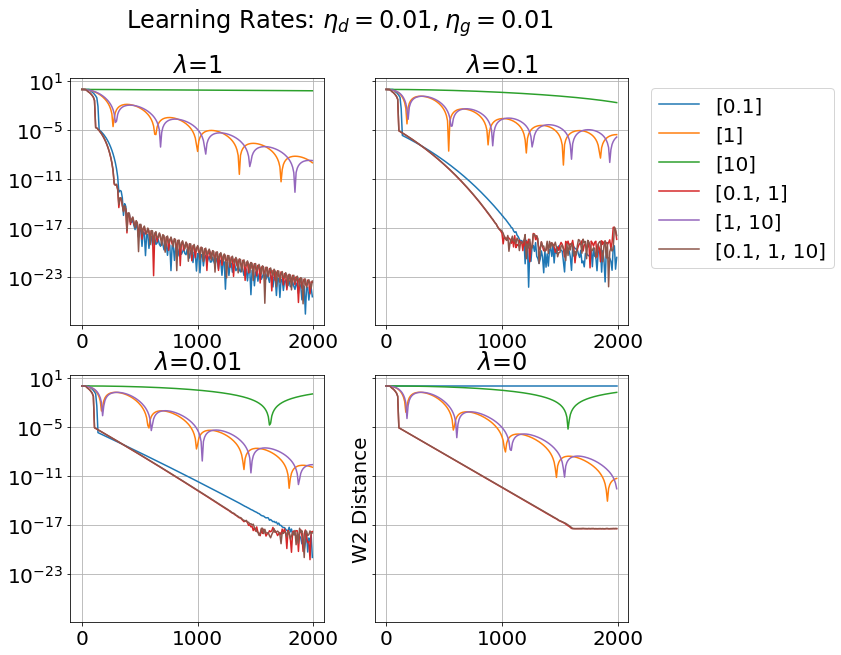

In [16]:
lr_index=3
fig, ax = plt.subplots(2,2,figsize=(10,10), sharey=True)
for j, lam in enumerate(lams):
    ax[j//2,j%2].set_title(f'$\lambda$={lam}')
    ax[j//2,j%2].grid()
    for k, width_param in enumerate(width_params):
        ax[j//2,j%2].semilogy(list(range(0,T,log_interval)), W_dist[lr_index,j, k,:], c=f'C{k}', label=f'{width_param}')

ax[0,1].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.ylabel('W2 Distance')
plt.suptitle(f'Learning Rates: $\eta_d={lr_combos[lr_index][0]},\eta_g={lr_combos[lr_index][1]}$')
plt.show()

In [24]:
import pickle 

# store all wdist histories into list of dictionaries
W2_list = []
list_to_str = lambda curr_list: '' if len(curr_list)==0 else f'_{curr_list[0]}{list_to_str(curr_list[1:])}'
for i, (lr_d, lr_g) in enumerate(lr_combos):
    for j, lam in enumerate(lams):
        for k, width_param in enumerate(width_params):
            W2_list.append({'lr_g':lr_g, 'lr_d':lr_d, 'lam':lam, 'width_param':width_param, 'W_dist':W_dist[i, j, k,:]})

with open('../data/Wdist_2point_mslkernel.pkl', 'wb') as f:
    pickle.dump(W2_list, f)

In [16]:
with open('../data/Wdist_2point_msgkernel.pkl', 'rb') as f:
    loaded_W2_list = pickle.load(f)

### RQ Kernel

In [25]:
# initializing discriminator kernel
width_params=[(1,1),(1,0.1),(1,1000),(0.1,1),(0.1,0.1),(0.1,1000)]
# varying across training params
T = 2000
lr_combos = [(1,1e-1),(1e-1,1e-1),(1e-1,1e-2),(1e-2,1e-2)] #(lr_d,lr_g)
lams = [1, 1e-1, 1e-2, 0]
log_interval=10

W_dist = np.zeros((len(lr_combos), len(lams), len(width_params), T//log_interval))
for k, (width_param,mix_param) in enumerate(width_params):
    # init kernel
    DK = Kernel('rq', width_param=width_param, mix_param=mix_param)
    for i, (lr_d,lr_g) in enumerate(lr_combos):
        for j, lam in enumerate(lams):
            # init gen points
            G = PointGenerator(X_gen_init, p_gen)
            # find generated trajectories
            model = KernelGAN(G, DK, device)
            model.train(X_true, p_true, lr_d, lr_g, T, lam)
            # calculate w2 distances
            curr_w2 = wasserstein2(model.G.X_gen.detach().cpu(), X_true.detach().cpu(), log_interval)
            W_dist[i, j, k, :] = curr_w2

100%|██████████| 200/200 [00:00<00:00, 1062.02it/s]


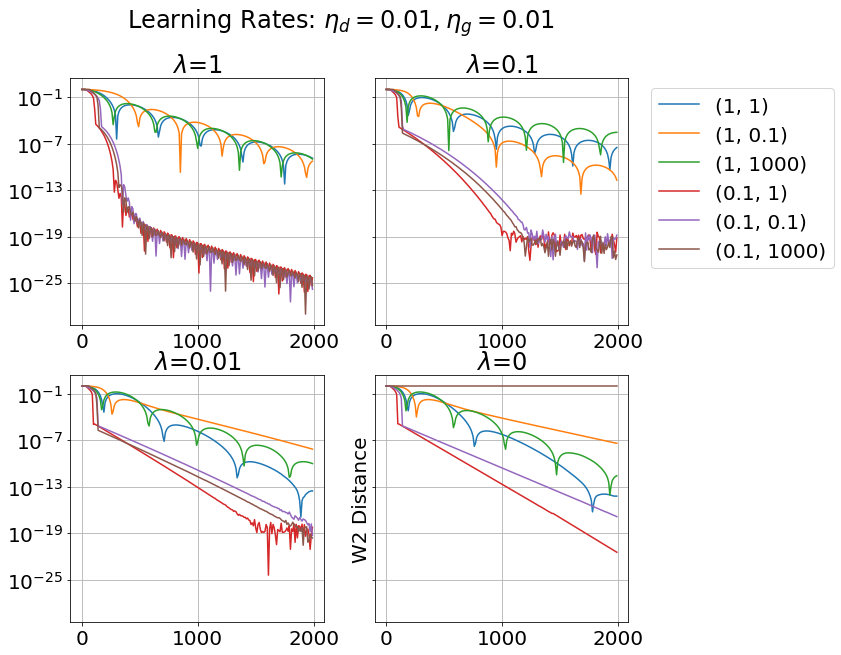

In [29]:
lr_index=3
fig, ax = plt.subplots(2,2,figsize=(10,10), sharey=True)
for j, lam in enumerate(lams):
    ax[j//2,j%2].set_title(f'$\lambda$={lam}')
    ax[j//2,j%2].grid()
    for k, (width_param,mix_param) in enumerate(width_params):
        ax[j//2,j%2].semilogy(list(range(0,T,log_interval)), W_dist[lr_index,j, k,:], 
                                c=f'C{k}', label=f'({width_param}, {mix_param})')

ax[0,1].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.ylabel('W2 Distance')
plt.suptitle(f'Learning Rates: $\eta_d={lr_combos[lr_index][0]},\eta_g={lr_combos[lr_index][1]}$')
plt.show()

In [30]:
import pickle 

# store all wdist histories into list of dictionaries
W2_list = []
list_to_str = lambda curr_list: '' if len(curr_list)==0 else f'_{curr_list[0]}{list_to_str(curr_list[1:])}'
for i, (lr_d, lr_g) in enumerate(lr_combos):
    for j, lam in enumerate(lams):
        for k, width_param in enumerate(width_params):
            W2_list.append({'lr_g':lr_g, 'lr_d':lr_d, 'lam':lam, 'width_param':width_param, 'W_dist':W_dist[i, j, k,:]})

with open('../data/Wdist_2point_rqkernel.pkl', 'wb') as f:
    pickle.dump(W2_list, f)